In [1]:
import pandas as pd
from cobra.io import read_sbml_model,load_yaml_model
from cobra.flux_analysis import double_gene_deletion
from tqdm import tqdm
from multiprocessing import freeze_support
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

In [9]:
#input files
data_path = "../../Data/analysis/data2016_in_model.xlsx"
generow_path = "../../Data/analysis/genelist_row.csv"
genecol_path = "../../Data/analysis/genelist_col.csv"
yeast_metatwin_gem_path = "../../Data/model/Yeast-MetaTwin.yml"
yeast8_gem_path = "../../Data/model/yeast-GEM902.yml"

#output files
yeast_metatwin_results_path = "../../Results/analysis/science2016_double_gene_deletion_results_yeast_metatwin.csv"
yeast8_results_path = "../../Results/analysis/science2016_double_gene_deletion_results_yeast8.csv"
figure_9e_path = '../../Results/Figures/figs9-e.pdf'

In [4]:
#Function to compute the number of true positive, true negative, false positive, and false negative based on the simulated and experimental results
def simu_exp(simu, exp, tp, tn, fp, fn):
    # tp
    if simu < 0.000001 and (exp == 'SL' or (-1000 <= exp <= -0.35)):
        tp += 1
    # tn
    elif simu > 0.000001 and (exp == 'SS' or exp > -0.35):
        tn += 1
    # fp
    elif simu < 0.000001 and (exp == 'SS' or exp > -0.35):
        fp += 1
    # fn
    elif simu > 0.000001 and (exp == 'SL' or (-1000 <= exp <= -0.35)):
        fn += 1
    return tp, tn, fp, fn

In [5]:

def yeast_double_gene_knockout(yeast8, generow, genecol, data2016, processes=100):
    tp = fp = fn = tn = 0
    
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Gene1', 'Gene2', 'Predicted Growth', 'genetic interactions scores'])
    deletion_result = double_gene_deletion(yeast8, generow, genecol, processes=processes)
    print('Run double gene deletion...')
    
    for row in tqdm(range(len(generow)), desc='Double gene deletion'):
        for col in range(len(genecol)):
            g1_sys = generow[row]
            g2_sys = genecol[col]
            if g1_sys == g2_sys:
                continue
            if g1_sys and g2_sys:
                growth = deletion_result[deletion_result['ids'] == {g1_sys, g2_sys}]['growth'].iloc[0]

                # compare predicted growth with experimental results
                tp, tn, fp, fn = simu_exp(growth, data2016.loc[g1_sys, g2_sys], tp, tn, fp, fn)

                # Append results to the DataFrame
                results = results.append({
                    'Gene1': g1_sys,
                    'Gene2': g2_sys,
                    'Predicted Growth': growth,
                    'genetic interactions scores': data2016.loc[g1_sys, g2_sys],
                }, ignore_index=True)


    print(f'tp={tp}\nfp={fp}\ntn={tn}\nfn={fn}')
    print('Finished')
    return results



In [14]:
# Load data and model
print('prepare data and model')
data2016 = pd.read_excel(data_path, index_col=0)
print(data2016.shape)
rows_to_drop = ['YMR084W']
cols_to_drop = ['YMR084W']
cols_to_drop = [col for col in cols_to_drop if col in data2016.columns]
rows_to_drop = [row for row in rows_to_drop if row in data2016.index]
data2016 = data2016.drop(index=rows_to_drop, columns=cols_to_drop)
print(data2016.shape)

generow = pd.read_csv(generow_path, header=None, dtype=str).squeeze("columns").tolist()
generow = [x for x in generow if x!='YMR084W']
genecol = pd.read_csv(genecol_path, header=None, dtype=str).squeeze("columns").tolist()

yeast8 = load_yaml_model(yeast8_gem_path)
yeast_metatwin = load_yaml_model(yeast_metatwin_gem_path)

prepare data and model


(727, 726)
(726, 726)


In [15]:
data2016

,YIL162W,YJL068C,YDR408C,YFL053W,YGR144W,YOR071C,YLL028W,YBR213W,YDL174C,YMR020W,...,YMR250W,YOL055C,YOR384W,YNR027W,YOR128C,YPL258C,YBR296C,YCR010C,YGL009C,YDR502C
YLR304C,-0.008,-0.014,0.096,-0.024,0.015,0.045,0.056,0.005,-1000.000,-1000.000,...,0.016,0.035,-0.022,-0.027,0.025,-0.046,-1000.000,-1000.000,-0.017,0.041
YLL018C-A,0.022,-0.050,-0.010,-0.015,-0.046,-0.002,-1000.000,-0.022,-0.138,-0.061,...,0.012,-0.015,-0.015,-0.023,-0.049,-0.054,0.013,-0.041,0.029,0.011
YAL039C,0.026,0.002,0.030,0.016,-0.002,-0.015,-0.015,-1000.000,0.025,0.010,...,-0.032,0.006,0.002,0.010,-0.043,-0.039,-0.003,-0.035,0.017,-0.041
YGR062C,0.034,-0.023,-0.038,-0.021,-1000.000,-0.002,0.003,-0.005,-0.055,-0.114,...,0.006,0.015,0.024,0.000,-0.019,-0.033,-0.007,0.001,-1000.000,-0.009
YDR268W,0.010,0.000,-1000.000,0.007,0.010,-0.029,0.021,0.009,-0.079,-0.006,...,0.001,0.001,-0.025,0.015,-0.007,-0.016,0.019,-0.029,0.010,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPL262W,0.018,0.021,-0.008,-0.017,0.021,-0.004,-0.044,0.009,0.001,0.093,...,0.030,0.033,-1000.000,-0.020,0.088,-1000.000,-0.022,-0.006,-0.009,-0.057
YLR089C,0.003,-0.041,-0.015,-0.029,-0.006,0.054,-1000.000,0.008,0.016,-0.009,...,-0.016,-0.056,-0.004,-0.040,-0.001,-0.009,0.001,0.013,-0.029,-0.009
YHR208W,-0.041,-0.047,0.029,-0.061,0.001,-0.004,-0.036,-0.026,-0.005,-0.045,...,0.011,-0.050,0.004,-0.019,-0.015,-0.027,0.037,-0.019,0.032,0.004
YNL037C,0.033,0.006,-0.003,0.006,-0.015,-0.047,-0.032,0.000,-0.035,-0.024,...,-1000.000,-0.024,-0.011,-1000.000,0.019,-0.023,-0.020,0.012,0.028,-0.014


In [16]:
print(data2016.index)   # 查看所有行名
print(data2016.columns) # 查看所有列名


Index(['YLR304C', 'YLL018C-A', 'YAL039C', 'YGR062C', 'YDR268W', 'YBL013W',
       'YIL160C', 'YHR162W', 'YBL080C', 'YPR047W',
       ...
       'YOR128C', 'YMR083W', 'YMR165C', 'YKL184W', 'YHR008C', 'YPL262W',
       'YLR089C', 'YHR208W', 'YNL037C', 'YOR136W'],
      dtype='object', length=726)
Index(['YIL162W', 'YJL068C', 'YDR408C', 'YFL053W', 'YGR144W', 'YOR071C',
       'YLL028W', 'YBR213W', 'YDL174C', 'YMR020W',
       ...
       'YMR250W', 'YOL055C', 'YOR384W', 'YNR027W', 'YOR128C', 'YPL258C',
       'YBR296C', 'YCR010C', 'YGL009C', 'YDR502C'],
      dtype='object', length=726)


In [17]:
# perform double gene knockout experiments with yeast8 model
yeast8_results = yeast_double_gene_knockout(yeast8, generow, genecol, data2016,processes=110)
yeast8_results.to_csv(yeast8_results_path, index=False)

Run double gene deletion...


Double gene deletion: 100%|██████████| 726/726 [6:26:12<00:00, 31.92s/it]  


tp=8495
fp=78993
tn=398347
fn=40681
Finished


In [18]:
#perform double gene knockout with yeast metatwin model
yeast_metatwin_results = yeast_double_gene_knockout(yeast_metatwin, generow, genecol, data2016,processes=110)
yeast_metatwin_results.to_csv(yeast_metatwin_results_path, index=False)

Run double gene deletion...


Double gene deletion: 100%|██████████| 726/726 [5:23:34<00:00, 26.74s/it]  


tp=4623
fp=41470
tn=435870
fn=44553
Finished


In [10]:
def draw_confusion_matrix_figure(yeast8_TP, yeast8_TN, yeast8_FP, yeast8_FN, yeast8_Accuracy, 
                                 yeast8U_TP, yeast8U_TN, yeast8U_FP, yeast8U_FN, yeast8U_Accuracy, 
                                 figure_path, vmax):
    # Assume you have two sets of confusion matrix data
    confusion_matrix1 = np.array([[yeast8_TP, yeast8_FP], [yeast8_FN, yeast8_TN]])
    confusion_matrix2 = np.array([[yeast8U_TP, yeast8U_FP], [yeast8U_FN, yeast8U_TN]])

    # Create a figure, set the subplot layout to 1 row and 2 columns, with the right subplot being narrower
    fig = plt.figure(figsize=(2, 1.6), dpi=400)
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['pdf.fonttype'] = 42
    
    gs = GridSpec(1, 3, width_ratios=[0.6, 0.6, 0.03])

    # First subplot
    ax1 = plt.subplot(gs[0])
    im1 = ax1.imshow(confusion_matrix1, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(False)
    ax1.text(0, 0, f"TP\n{confusion_matrix1[0, 0]}", ha='center', va='center', fontsize=5, color='black')
    ax1.text(1, 0, f"FP\n{confusion_matrix1[0, 1]}", ha='center', va='center', fontsize=5, color='black')
    ax1.text(0, 1, f"FN\n{confusion_matrix1[1, 0]}", ha='center', va='center', fontsize=5, color='black')
    ax1.text(1, 1, f"TN\n{confusion_matrix1[1, 1]}", ha='center', va='center', fontsize=5, color='black')
    ax1.set_xlabel(f"Yeast9\n(ACC = {yeast8_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Second subplot
    ax2 = plt.subplot(gs[1])
    im2 = ax2.imshow(confusion_matrix2, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)
    ax2.text(0, 0, f"TP\n{confusion_matrix2[0, 0]}", ha='center', va='center', fontsize=5, color='black')
    ax2.text(1, 0, f"FP\n{confusion_matrix2[0, 1]}", ha='center', va='center', fontsize=5, color='black')
    ax2.text(0, 1, f"FN\n{confusion_matrix2[1, 0]}", ha='center', va='center', fontsize=5, color='black')
    ax2.text(1, 1, f"TN\n{confusion_matrix2[1, 1]}", ha='center', va='center', fontsize=5, color='black')
    ax2.set_xlabel(f"Yeast-MetaTwin\n(ACC = {yeast8U_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Color bar
    cbar_ax = plt.subplot(gs[2])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    # Add border to the image
    for spine in cbar_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.02)
    # Save the image to a file
    plt.savefig(figure_path, dpi=400, bbox_inches='tight')
    plt.show()

In [7]:
yeast8_TP = 8495
yeast8_TN = 398347
yeast8_FP = 78993
yeast8_FN = 40681
yeast8_Accuracy = (yeast8_TP + yeast8_TN) / (yeast8_TP + yeast8_TN + yeast8_FP + yeast8_FN)
print(yeast8_Accuracy)

yeast8U_TP = 4623
yeast8U_TN = 435870
yeast8U_FP = 41470
yeast8U_FN = 44553
yeast8U_Accuracy = (yeast8U_TP + yeast8U_TN) / (yeast8U_TP + yeast8U_TN + yeast8U_FP + yeast8U_FN)
print(yeast8U_Accuracy)

0.7727058626898328
0.8366184503414901


meta NOT subset; don't know how to subset; dropped


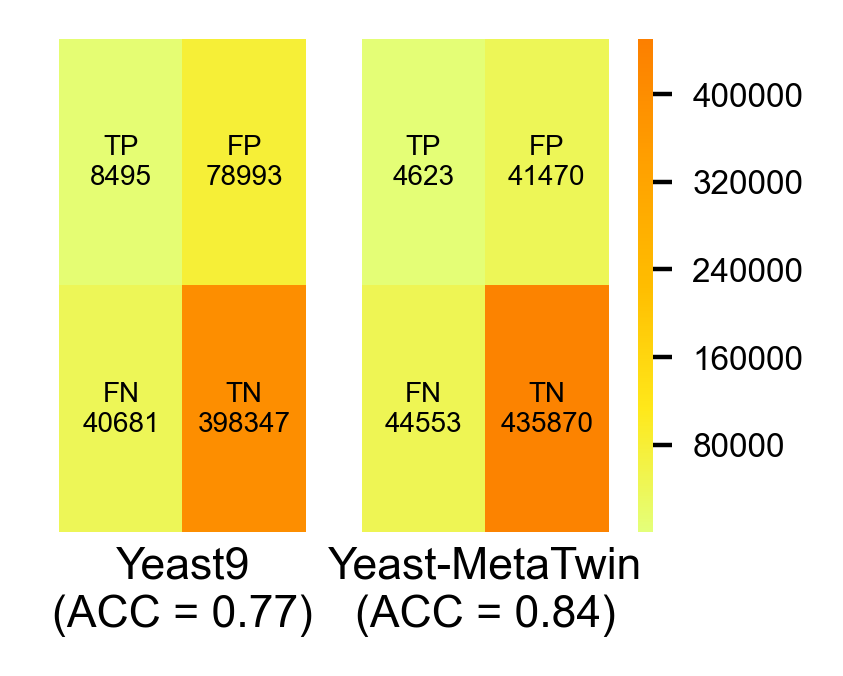

In [11]:
draw_confusion_matrix_figure(yeast8_TP, yeast8_TN, yeast8_FP, yeast8_FN, yeast8_Accuracy, 
                                 yeast8U_TP, yeast8U_TN, yeast8U_FP, yeast8U_FN, yeast8U_Accuracy, 
                                 figure_9e_path, 450000)